In [ ]:
GPU 확인

In [1]:
import torch

# PyTorch 버전 확인
print("PyTorch version:", torch.__version__)

# GPU 사용 가능 여부 확인
if torch.cuda.is_available():
    print("GPU is available!")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")


PyTorch version: 1.9.0+cu111
GPU is available!
Device name: NVIDIA GeForce RTX 3080


In [ ]:
JSON의 state값과 동일한 제목의 bin파일을 기준으로 모델 실험

In [2]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


# 1. 데이터 전처리 및 로더 생성
class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for root, _, files in os.walk(root_folder):
            for file in files:
                if file.endswith(".bin"):
                    bin_path = os.path.join(root, file)
                    json_path = bin_path.replace(".bin", ".json")

                    try:
                        # BIN 파일 읽기 (120x160 이미지)
                        bin_data = np.load(bin_path, allow_pickle=True).astype(np.float32)
                        bin_data = bin_data.reshape((120, 160))
                    except (UnicodeDecodeError, ValueError):
                        print(f"[Error] BIN 파일 읽기 실패: {bin_path}")
                        continue

                    # JSON 파일에서 state 값 읽기
                    if os.path.exists(json_path):
                        with open(json_path, "r", encoding="utf-8") as json_file:
                            json_data = json.load(json_file)
                            state = json_data.get("annotations", [{}])[0].get("tagging", [{}])[0].get("state", "N/A")
                    else:
                        print(f"[Warning] JSON 파일을 찾을 수 없습니다: {json_path}")
                        continue

                    self.data.append(bin_data)
                    self.labels.append(state)

        # Label Encoding
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

        print(f"폴더: {root_folder}, 데이터 개수: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # PyTorch 텐서 변환 및 채널 추가
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, 120, 160)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


def load_data(data_folder, batch_size=32):
    train_dataset = CustomDataset(os.path.join(data_folder, "train"))
    val_dataset = CustomDataset(os.path.join(data_folder, "val"))
    test_dataset = CustomDataset(os.path.join(data_folder, "test"))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

폴더: C:/Users/82103/Desktop/multimodal/AGV\train, 데이터 개수: 35375
폴더: C:/Users/82103/Desktop/multimodal/AGV\val, 데이터 개수: 5052
폴더: C:/Users/82103/Desktop/multimodal/AGV\test, 데이터 개수: 5052
Using device: cuda
Epoch 1/10, Train Loss: 0.5416, Val Loss: 1.0421, Val Accuracy: 62.21%
Epoch 2/10, Train Loss: 0.4674, Val Loss: 1.0246, Val Accuracy: 68.92%
Epoch 3/10, Train Loss: 0.4513, Val Loss: 0.9424, Val Accuracy: 62.89%
Epoch 4/10, Train Loss: 0.4433, Val Loss: 0.9607, Val Accuracy: 70.21%
Epoch 5/10, Train Loss: 0.4360, Val Loss: 0.9574, Val Accuracy: 69.36%
Epoch 6/10, Train Loss: 0.4126, Val Loss: 1.0910, Val Accuracy: 68.98%
Epoch 7/10, Train Loss: 0.4077, Val Loss: 0.9181, Val Accuracy: 72.59%
Epoch 8/10, Train Loss: 0.4016, Val Loss: 1.0891, Val Accuracy: 71.79%
Epoch 9/10, Train Loss: 0.3978, Val Loss: 1.0091, Val Accuracy: 71.99%
Epoch 10/10, Train Loss: 0.3948, Val Loss: 1.0912, Val Accuracy: 72.25%
Test Loss: 1.2622, Test Accuracy: 71.10%


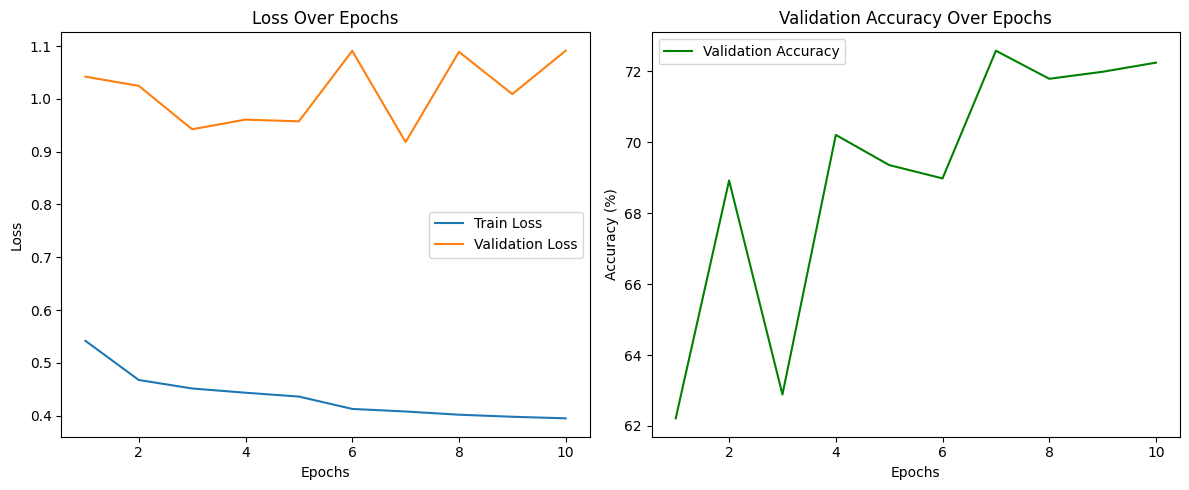

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth):
        super().__init__()
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True
        )
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        return x.mean(dim=1)  # [batch_size, embed_dim]


class ViTClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, num_classes):
        super(ViTClassifier, self).__init__()
        self.feature_extractor = ViTFeatureExtractor(
            img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


# 3. 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # 학습률 스케줄러 업데이트 (scheduler가 있을 경우에만 실행)
        if scheduler is not None:
            scheduler.step()

        # 검증
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, "
              f"Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies


# 4. 테스트 함수
def test_model(model, test_loader):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return test_loss / len(test_loader), test_accuracy


# 5. 결과 시각화
def plot_results(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


# 6. 실행
if __name__ == "__main__":
    data_folder = "C:/Users/82103/Desktop/multimodal/AGV"
    batch_size = 16
    train_loader, val_loader, test_loader = load_data(data_folder, batch_size)

    # GPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 모델 생성
    model = ViTClassifier(
        img_dim_h=120, img_dim_w=160, patch_size=16, embed_dim=128,
        num_heads=4, depth=5, num_classes=4
    ).to(device)

    # Optimizer 및 손실 함수 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    # Optional: Learning Rate Scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # 학습
    num_epochs = 10
    train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )

    # 테스트
    test_model(model, test_loader)

    # 결과 시각화
    plot_results(train_losses, val_losses, val_accuracies)

폴더: C:/Users/82103/Desktop/multimodal/AGV\train, 데이터 개수: 35375
폴더: C:/Users/82103/Desktop/multimodal/AGV\val, 데이터 개수: 5052
폴더: C:/Users/82103/Desktop/multimodal/AGV\test, 데이터 개수: 5052
Using device: cuda
Epoch 1/10, Train Loss: 0.5271, Val Loss: 1.1543, Val Accuracy: 61.12%
Epoch 2/10, Train Loss: 0.4573, Val Loss: 1.0837, Val Accuracy: 69.16%
Epoch 3/10, Train Loss: 0.4423, Val Loss: 1.3808, Val Accuracy: 64.69%
Epoch 4/10, Train Loss: 0.4313, Val Loss: 1.1399, Val Accuracy: 66.45%
Epoch 5/10, Train Loss: 0.4240, Val Loss: 1.3565, Val Accuracy: 63.68%
Epoch 6/10, Train Loss: 0.4012, Val Loss: 1.5851, Val Accuracy: 63.86%
Epoch 7/10, Train Loss: 0.3930, Val Loss: 1.4246, Val Accuracy: 66.19%
Epoch 8/10, Train Loss: 0.3906, Val Loss: 1.6522, Val Accuracy: 64.13%
Epoch 9/10, Train Loss: 0.3855, Val Loss: 1.6006, Val Accuracy: 62.49%
Epoch 10/10, Train Loss: 0.3871, Val Loss: 1.7406, Val Accuracy: 62.27%
Test Loss: 2.0966, Test Accuracy: 61.70%


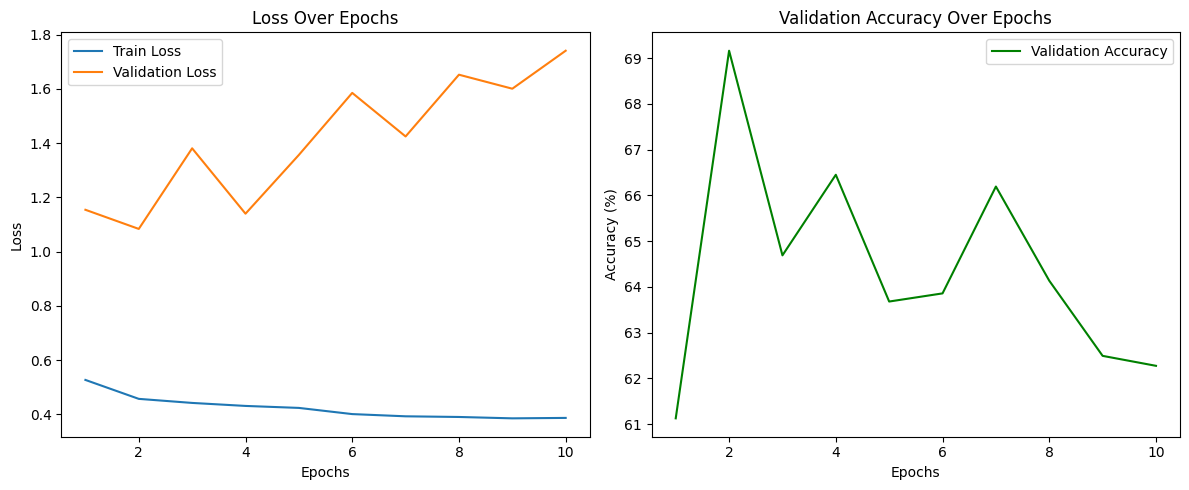

In [14]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. 데이터 전처리 및 로더 생성
class CustomDataset(Dataset):
    def __init__(self, root_folder, csv_path, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        # CSV 파일 로드
        self.label_data = pd.read_csv(csv_path)
        self.label_data.set_index("bin_filename", inplace=True)

        for root, _, files in os.walk(root_folder):
            for file in files:
                if file.endswith(".bin"):
                    bin_path = os.path.join(root, file)

                    try:
                        bin_data = np.load(bin_path, allow_pickle=True).astype(np.float32)
                        bin_data = bin_data.reshape((120, 160))
                    except Exception as e:
                        print(f"[Error] BIN 파일 읽기 실패: {bin_path}, {e}")
                        continue

                    bin_filename = os.path.basename(file)
                    if bin_filename in self.label_data.index:
                        state = self.label_data.loc[bin_filename, "state"]
                        self.data.append(bin_data)
                        self.labels.append(state)
                    else:
                        print(f"[Warning] CSV에서 매핑되지 않은 BIN 파일: {bin_filename}")

        # Label Encoding
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

        print(f"폴더: {root_folder}, 데이터 개수: {len(self.data)}")


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # PyTorch 텐서 변환 및 채널 추가
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, 120, 160)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


def load_data(data_folder, csv_path, batch_size=32):
    train_dataset = CustomDataset(os.path.join(data_folder, "train"), csv_path)
    val_dataset = CustomDataset(os.path.join(data_folder, "val"), csv_path)
    test_dataset = CustomDataset(os.path.join(data_folder, "test"), csv_path)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 2. 모델 정의 (기존 코드 유지)
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth):
        super().__init__()
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True
        )
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        return x.mean(dim=1)  # [batch_size, embed_dim]


class ViTClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, num_classes):
        super(ViTClassifier, self).__init__()
        self.feature_extractor = ViTFeatureExtractor(
            img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


# 3. 실행
if __name__ == "__main__":
    data_folder = "C:/Users/82103/Desktop/multimodal/AGV"
    csv_path = "C:/Users/82103/Desktop/multimodal/AGV/agv_merged_output.csv"  # 병합된 CSV 파일 경로
    batch_size = 16

    # 데이터 로더 생성
    train_loader, val_loader, test_loader = load_data(data_folder, csv_path, batch_size)

    # GPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 모델 생성
    model = ViTClassifier(
        img_dim_h=120, img_dim_w=160, patch_size=8, embed_dim=128,
        num_heads=8, depth=8, num_classes=4
    ).to(device)

    # Optimizer 및 손실 함수 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    # Optional: Learning Rate Scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # 학습
    num_epochs = 10
    train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )

    # 테스트
    test_model(model, test_loader)

    # 결과 시각화
    plot_results(train_losses, val_losses, val_accuracies)


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. 데이터 전처리 및 로더 생성
class CustomDataset(Dataset):
    def __init__(self, root_folder, csv_path, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        # CSV 파일 로드
        self.label_data = pd.read_csv(csv_path)
        self.label_data.set_index("bin_filename", inplace=True)

        for root, _, files in os.walk(root_folder):
            for file in files:
                if file.endswith(".bin"):
                    bin_path = os.path.join(root, file)

                    try:
                        bin_data = np.load(bin_path, allow_pickle=True).astype(np.float32)
                        bin_data = bin_data.reshape((120, 160))
                    except Exception as e:
                        print(f"[Error] BIN 파일 읽기 실패: {bin_path}, {e}")
                        continue

                    bin_filename = os.path.basename(file)
                    if bin_filename in self.label_data.index:
                        state = self.label_data.loc[bin_filename, "state"]
                        self.data.append(bin_data)
                        self.labels.append(state)
                    else:
                        print(f"[Warning] CSV에서 매핑되지 않은 BIN 파일: {bin_filename}")

        # Label Encoding
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

        print(f"폴더: {root_folder}, 데이터 개수: {len(self.data)}")


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # PyTorch 텐서 변환 및 채널 추가
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, 120, 160)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


def load_data(data_folder, csv_path, batch_size=32):
    train_dataset = CustomDataset(os.path.join(data_folder, "train"), csv_path)
    val_dataset = CustomDataset(os.path.join(data_folder, "val"), csv_path)
    test_dataset = CustomDataset(os.path.join(data_folder, "test"), csv_path)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 2. 모델 정의 (기존 코드 유지)
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth):
        super().__init__()
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True
        )
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        return x.mean(dim=1)  # [batch_size, embed_dim]


class ViTClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, num_classes):
        super(ViTClassifier, self).__init__()
        self.feature_extractor = ViTFeatureExtractor(
            img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


# 3. 실행
if __name__ == "__main__":
    data_folder = "C:/Users/82103/Desktop/multimodal/OHT"
    csv_path = "C:/Users/82103/Desktop/multimodal/OHT/oht_merged_output.csv"  # 병합된 CSV 파일 경로
    batch_size = 16

    # 데이터 로더 생성
    train_loader, val_loader, test_loader = load_data(data_folder, csv_path, batch_size)

    # GPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 모델 생성
    model = ViTClassifier(
        img_dim_h=120, img_dim_w=160, patch_size=8, embed_dim=128,
        num_heads=8, depth=8, num_classes=4
    ).to(device)

    # Optimizer 및 손실 함수 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    # Optional: Learning Rate Scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # 학습
    num_epochs = 10
    train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )

    # 테스트
    test_model(model, test_loader)

    # 결과 시각화
    plot_results(train_losses, val_losses, val_accuracies)


폴더: C:/Users/82103/Desktop/multimodal/OHT\train, 데이터 개수: 51707
폴더: C:/Users/82103/Desktop/multimodal/OHT\val, 데이터 개수: 7342


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. 데이터 전처리 및 로더 생성
class CustomDataset(Dataset):
    def __init__(self, root_folder, csv_path, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        # CSV 파일 로드
        self.label_data = pd.read_csv(csv_path)
        self.label_data.set_index("bin_filename", inplace=True)

        for root, _, files in os.walk(root_folder):
            for file in files:
                if file.endswith(".bin"):
                    bin_path = os.path.join(root, file)

                    try:
                        bin_data = np.load(bin_path, allow_pickle=True).astype(np.float32)
                        bin_data = bin_data.reshape((120, 160))
                    except Exception as e:
                        print(f"[Error] BIN 파일 읽기 실패: {bin_path}, {e}")
                        continue

                    bin_filename = os.path.basename(file)
                    if bin_filename in self.label_data.index:
                        state = self.label_data.loc[bin_filename, "state"]
                        self.data.append(bin_data)
                        self.labels.append(state)
                    else:
                        print(f"[Warning] CSV에서 매핑되지 않은 BIN 파일: {bin_filename}")

        # Label Encoding
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

        print(f"폴더: {root_folder}, 데이터 개수: {len(self.data)}")


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # PyTorch 텐서 변환 및 채널 추가
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, 120, 160)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


def load_data(data_folder, csv_path, batch_size=32):
    train_dataset = CustomDataset(os.path.join(data_folder, "train"), csv_path)
    val_dataset = CustomDataset(os.path.join(data_folder, "val"), csv_path)
    test_dataset = CustomDataset(os.path.join(data_folder, "test"), csv_path)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 2. 모델 정의 (기존 코드 유지)
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth):
        super().__init__()
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True
        )
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        return x.mean(dim=1)  # [batch_size, embed_dim]


class ViTClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, num_classes):
        super(ViTClassifier, self).__init__()
        self.feature_extractor = ViTFeatureExtractor(
            img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


# 3. 실행
if __name__ == "__main__":
    data_folder = "C:/Users/82103/Desktop/multimodal/OHT"
    csv_path = "C:/Users/82103/Desktop/multimodal/OHT/oht_merged_output.csv"  # 병합된 CSV 파일 경로
    batch_size = 32

    # 데이터 로더 생성
    train_loader, val_loader, test_loader = load_data(data_folder, csv_path, batch_size)

    # GPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 모델 생성
    model = ViTClassifier(
        img_dim_h=120, img_dim_w=160, patch_size=8, embed_dim=128,
        num_heads=8, depth=8, num_classes=4
    ).to(device)

    # Optimizer 및 손실 함수 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    # Optional: Learning Rate Scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # 학습
    num_epochs = 10
    train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )

    # 테스트
    test_model(model, test_loader)

    # 결과 시각화
    plot_results(train_losses, val_losses, val_accuracies)
